In [1]:
from copy import copy

import torch
import pytorch_lightning as pl
import numpy as np

from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf

from ens_transformer.data_module import IFSERADataModule

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

In [2]:
pl.seed_everything(42)

Global seed set to 42


42

In [3]:
with initialize(config_path="../data/models/transformer_scale/transformer_1_20/hydra"):
    cfg = compose('config.yaml')

In [4]:
ens_net = instantiate(
    cfg.model,
    in_channels=len(cfg.data.include_vars),
    learning_rate=cfg.learning_rate
)
ens_net = ens_net.load_from_checkpoint("../data/models/transformer_scale/transformer_1_20/last.ckpt", map_location=torch.device('cpu'))

In [5]:
data_module = instantiate(cfg['data']['data_module'], pin_memory=False)
data_module.setup()

In [6]:
selected_date = '2019-09-01 00:00'

In [7]:
selected_time_ens = data_module.ds_test.ifs.sel(time=selected_date)
selected_time_target = data_module.ds_test.era5.sel(time=selected_date)

In [8]:
ifs_data = data_module.ds_test.input_transform(selected_time_ens.values)[None, :]

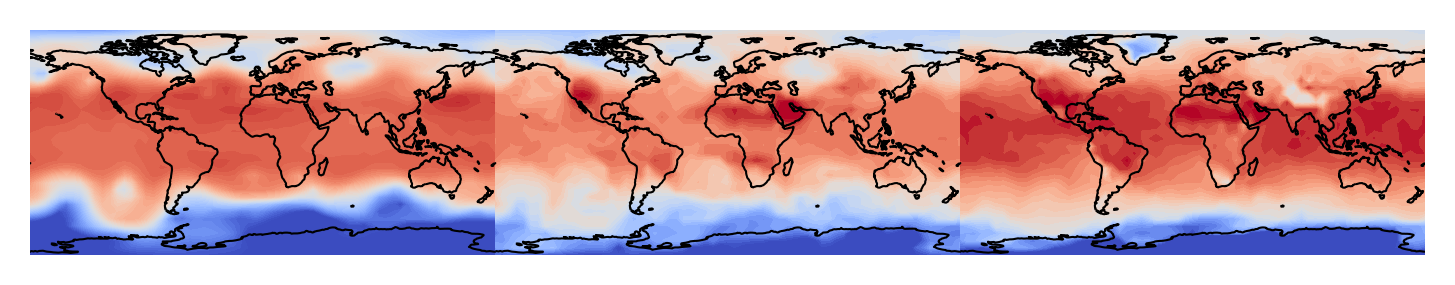

In [9]:
fig, ax = plt.subplots(ncols=3, subplot_kw={'projection': ccrs.PlateCarree()}, dpi=300)
g500_plt, lons = add_cyclic_point(selected_time_ens.sel(var_name='gh_500')[0].values.squeeze(), coord=selected_time_ens['longitude'])
ax[0].contourf(lons, selected_time_ens['latitude'], g500_plt, cmap='coolwarm',
               levels=np.linspace(5000, 6000, 51), vmin=5000, vmax=6000, extend='both')
ax[0].coastlines(linewidth=0.5)
t850_plt, lons = add_cyclic_point(selected_time_ens.sel(var_name='t_850')[0].values.squeeze(), coord=selected_time_ens['longitude'])
ax[1].contourf(lons, selected_time_ens['latitude'], t850_plt, cmap='coolwarm',
               levels=np.linspace(243.15, 303.15, 31), vmin=243.15, vmax=303.15, extend='both')
ax[1].coastlines(linewidth=0.5)
t2m_plt, lons = add_cyclic_point(selected_time_ens.sel(var_name='t2m')[0].values.squeeze(), coord=selected_time_ens['longitude'])
ax[2].contourf(lons, selected_time_ens['latitude'], t2m_plt, cmap='coolwarm',
               levels=np.linspace(243.15, 303.15, 31), vmin=243.15, vmax=303.15, extend='both')
ax[2].coastlines(linewidth=0.5)
fig.subplots_adjust(wspace=0.)
#fig.patch.set_visible(True)
for sub_ax in ax:
    sub_ax.axis('off')
fig.savefig('../paper/figures/overview_ifs.png', dpi=300, bbox_inches='tight')

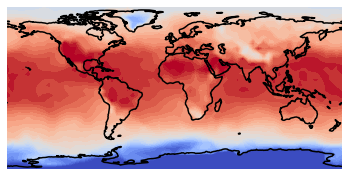

In [10]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
t2m_plt, lons = add_cyclic_point(selected_time_target.values, coord=selected_time_target['longitude'])
ax.contourf(lons, selected_time_target['latitude'], t2m_plt, cmap='coolwarm',
               levels=np.linspace(-30, 30, 31), vmin=-30, vmax=30, extend='both')
ax.coastlines(linewidth=1.5)
fig.subplots_adjust(wspace=0.)
ax.axis('off')
fig.savefig('../paper/figures/target_schematic.png', dpi=300, bbox_inches='tight')

In [11]:
with torch.no_grad():
    embedding = ens_net.embedding(ifs_data).squeeze().mean(dim=0)

In [12]:
embedding_plt, lons = add_cyclic_point(embedding, coord=selected_time_ens['longitude'])

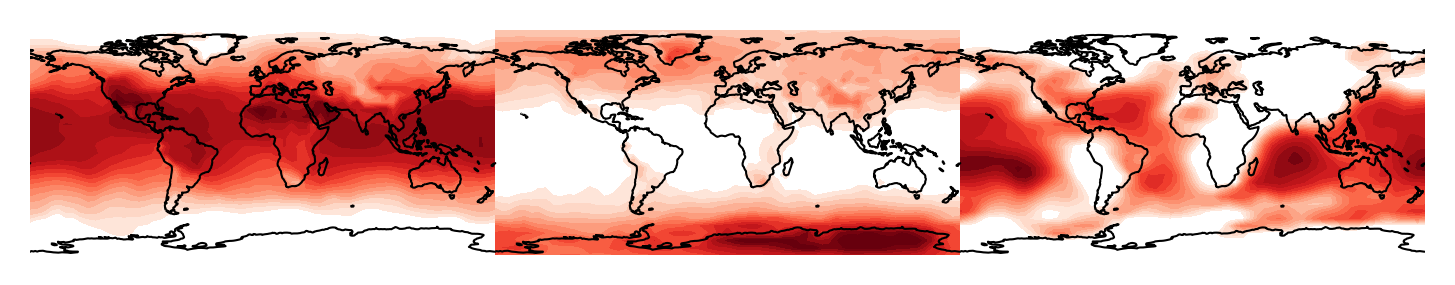

In [13]:
reds = copy(plt.get_cmap('Reds'))
reds.set_under('white')

fig, ax = plt.subplots(ncols=3, subplot_kw={'projection': ccrs.PlateCarree()}, dpi=300)
ax[0].contourf(lons, selected_time_ens['latitude'], embedding_plt[1],
               levels=21, vmin=0, extend='both', cmap=reds)
ax[0].coastlines(linewidth=0.5)
ax[1].contourf(lons, selected_time_ens['latitude'], embedding_plt[3],
               levels=21, vmin=0, extend='both', cmap=reds)
ax[1].coastlines(linewidth=0.5)
ax[2].contourf(lons, selected_time_ens['latitude'], embedding_plt[-6],
               levels=21, vmin=0, extend='both', cmap=reds)
ax[2].coastlines(linewidth=0.5)
fig.subplots_adjust(wspace=0.)
#fig.patch.set_visible(True)
for sub_ax in ax:
    sub_ax.axis('off')
fig.savefig('../paper/figures/overview_embedding.png', dpi=300, bbox_inches='tight')